In [1]:
print("Hello, World!")

Hello, World!


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

llm = init_chat_model("google_genai:gemini-2.0-flash-001")


In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph = graph_builder.compile()

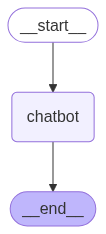

In [7]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant: ", value["messages"][-1].content)

# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["exit", "quit", "q"]:
#             print("Exiting...")
#             break
#         stream_graph_updates(user_input)
#     except :
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

Exiting...


In [9]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)

tools = [tool]

tool.invoke("What's a node in langgraph?")

{'query': "What's a node in langgraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge("r

In [10]:
llm_with_tools = llm.bind_tools([tool])

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [12]:
from langchain_core.messages import ToolMessage
from typing import Dict
import json

class BasicToolNode:
    """A node that runs the tools required in the last AiMessage"""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, input: Dict):
        if messages := input.get("messages",[]):
            message = messages[-1]
        else:
            raise ValueError("No messages in the input")
        
        outputs = []

        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)




In [13]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

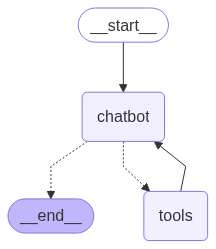

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I am sorry, I cannot fulfill this request. The available tools lack the functionality to provide weather information.
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchain), is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize [large language models](https://www.ibm.com/think/topics/large-language-models) (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the [...] By using a graph-based architecture, LangGraph enables users to scale artificial intelligence workflows without slowing down or sacrificing efficiency. 

/Users/rohitmore/GitHub/agentic-ai/tutorials/langgraph/basics/venv/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is LangGraph? - IBM", "url": "https://www.ibm.com/think/topics/langgraph", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent\u2019s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Lan

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [17]:
graph.invoke({"messages": [{"role": "user", "content": "What is the current population of France?"}]})

{'messages': [HumanMessage(content='What is the current population of France?', additional_kwargs={}, response_metadata={}, id='bef372b8-2ec0-41cc-8d5f-b1793d6848b2'),
  AIMessage(content='I cannot directly answer that question using the available tools. However, I can use the search tool to find the current population of France. What search query would you like me to use?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--fd7dbfd4-6e03-46d4-8870-a591bcc90cba-0', usage_metadata={'input_tokens': 491, 'output_tokens': 38, 'total_tokens': 529, 'input_token_details': {'cache_read': 0}})]}

In [19]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [20]:
graph = graph_builder.compile(checkpointer=memory)

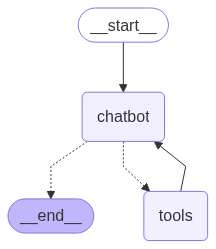

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi There, my name is Rohit"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi There, my name is Rohit
================================== Ai Message ==================================

Hello Rohit, nice to meet you. How can I help you today?


In [23]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Rohit.


In [24]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config={"configurable": {"thread_id": "2"}},
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not have memory of previous conversations.


In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi There, my name is Rohit', additional_kwargs={}, response_metadata={}, id='1ec45726-7ab5-4706-ace1-05d00df52ae7'), AIMessage(content='Hello Rohit, nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e88452c6-f962-4e7a-8b20-889c81b45642-0', usage_metadata={'input_tokens': 490, 'output_tokens': 16, 'total_tokens': 506, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='a4c89e3d-b97d-4448-9f08-fbf143ff6328'), AIMessage(content='Yes, your name is Rohit.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--b26c2a43-776

In [27]:
snapshot.next

()

In [28]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [29]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

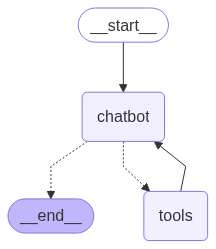

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (2dc00670-e950-4e55-9cc5-3194a3112d14)
 Call ID: 2dc00670-e950-4e55-9cc5-3194a3112d14
  Args:
    query: I need some expert guidance for building an AI agent.


In [32]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [33]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (2dc00670-e950-4e55-9cc5-3194a3112d14)
 Call ID: 2dc00670-e950-4e55-9cc5-3194a3112d14
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph to build your agent. They say it's more reliable and extensible than simple autonomous agents.


In [34]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [35]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [36]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)



tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [37]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5339fa6f-d514-44bf-a3ba-ff19b5a938ea)
 Call ID: 5339fa6f-d514-44bf-a3ba-ff19b5a938ea
  Args:
    topic: general
    query: when was LangGraph released?
================================= Tool Message =================================
Name: tavily_search

{"query": "when was LangGraph released?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Releases · langchain-ai/langgraph - GitHub", "url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub *   fix(langgraph): remove deprecated `output` usage in favor of `output_schema` (#5095) *   Remove Checkpoint.writes (#4822) *   Remove old checkpoint test

In [41]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I found that LangGraph v0.1 was announced on January 22, 2024, according to the LangChain changelog. However, I encountered an error when trying to use the human\_assistance tool to confirm. Can you confirm the release date using the human\_assistance tool?


In [42]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{}